# Import Data from XLS

In [94]:
# Second commit

import pandas as pd
import numpy as np

def xls_to_np(file_path, num_therms=1):
    # Generate numpy arrays to store isotherm data
    host_conc = np.empty(num_therms, dtype=object)
    guest_conc = np.empty(num_therms, dtype=object)
    response = np.empty(num_therms, dtype=object)

    # Open 
    data_as_pd = pd.read_excel(file_path)

    for i in range(num_therms):
        host_conc[i] = data_as_pd['Guest Concentration ' + str(i + 1)].values
        guest_conc[i] = data_as_pd['Guest Concentration ' + str(i + 1)].values
        response[i] = data_as_pd['Response ' + str(i + 1)].values

    return host_conc, guest_conc, response

# NMR 1:1 Model

In [89]:
def nmr_1to1(k, host_conc, guest_conc):
    """
    Calculates predicted [HG] given data object parameters as input.
    """
 
    h0 = host_conc
    g0 = guest_conc

    # Calculate predicted [HG] concentration given input [H]0, [G]0 matrices 
    # and Ka guess
    hg = 0.5*(\
             (g0 + h0 + (1/k)) - \
             np.lib.scimath.sqrt(((g0+h0+(1/k))**2)-(4*((g0*h0))))\
             )
    h  = h0 - hg

    # Replace any non-real solutions with sqrt(h0*g0) 
    inds = np.imag(hg) > 0
    hg[inds] = np.sqrt(h0[inds] * g0[inds])

    # Convert [HG] concentration to molefraction for NMR
    hg /= h0
    h  /= h0

    return hg, h

# Scale Data (Convert Chemical Shift to Relative Units)

In [90]:
def scale_data(chem_shift_data, fitted_data=None, scale_data=False, manual_scale_factor=0):
    # Subtract initial chemical shift
    init_chem_shift = chem_shift_data[0]
    zeroed_data = chem_shift_data - init_chem_shift
    if scale_data == True:
        scale_factor = manual_scale_factor
    else:
        scale_factor = fitted_data[-1] / zeroed_data[-1]
    return zeroed_data * scale_factor

# Optimization by Nelder-Mead

In [97]:
import numpy as np
from scipy.optimize import minimize

INITIAL_GUESS = np.array([400, 0.5, 0])
init_host_conc, init_guest_conc, response = xls_to_np("C:\\Users\\elijo\\OneDrive\\Desktop\\YC4xp.xlsx")
init_host_conc = init_host_conc[0]
init_guest_conc = init_guest_conc[0]
response = response[0]

#print(init_host_conc)

def cost_function(args):
    # Arguments
    binding_constant = args[0]
    scale_factor = args[1]
    intercept = args[2]

    # Generate predicted response
    pred_response =  nmr_1to1(binding_constant, init_host_conc, init_guest_conc)[0]
    pred_response -= intercept
    
    # Scale experimental data by manual_scale_factor
    new_response = scale_data(response, scale_data=True, manual_scale_factor=scale_factor)

    # Determine number of elements
    max_value = new_response[-1]

    # Calculate MSE
    mse = np.mean(((pred_response - new_response)/max_value)**2)
    return mse

def minimize_function():
    result = minimize(cost_function, INITIAL_GUESS, method='nelder-mead')
    return result.x[0], result.x[1], result.x[2]

print("Binding Constant: " + str(minimize_function()[0]))
print("Scaling Factor: " + str(minimize_function()[1]))
print("Intercept: " + str(minimize_function()[2]))

Binding Constant: 7362.465524503459
Scaling Factor: 0.12332016583474417
Intercept: 0.7877348917132698


# Implement

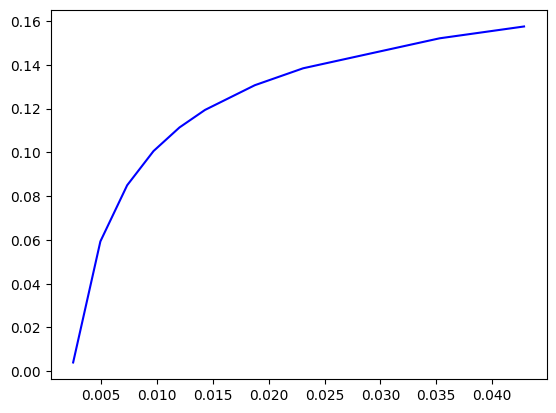

In [99]:
import matplotlib.pyplot as plt

#init_host_conc, init_guest_conc, response = xls_to_np("C:\\Users\\elijo\\OneDrive\\Desktop\\YC4xp.xlsx")
binding_constant, scaling_factor, intercept = minimize_function()

# Generate predicted response
pred_response =  nmr_1to1(binding_constant, init_host_conc, init_guest_conc)[0]
pred_response -= intercept

# Scale experimental data by manual_scale_factor
new_response = scale_data(response, scale_data=True, manual_scale_factor=scaling_factor)

plt.plot(init_guest_conc, pred_response, color='blue')
#plt.scatter(init_guest_conc, response, color='red')

#print(cost_function(d1, scale_factor))

#x_axis = np.linspace(653.4, 654.3, num=50)
#reaction = np.zeros(50)
#for i in range(50):
    #reaction[i] = cost_function(x_axis[i], scale_factor)
#plt.scatter(thinie, reaction)
